In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.5 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, GlobalMaxPool1D, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer
from tensorflow.keras.layers import GlobalMaxPooling1D, BatchNormalization

In [ ]:
data = pd.read_csv("task2b.csv")

In [ ]:
data['nlabel'].unique()

array([False,  True])

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
tokens = []
for text in data["Generation"]:
  tokens.append(tokenizer.tokenize(text))

In [ ]:
token_ids = []
for token in tokens:
  token_ids.append(tokenizer.convert_tokens_to_ids(token))

In [ ]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

# Tokenize the text into words and sentences
feature = []
for corpus in data["Generation"]:
  words = word_tokenize(corpus)
  sentences = sent_tokenize(corpus)
  word_lengths = [len(w) for w in words if w not in stopwords.words('english')]
  avg_word_length = sum(word_lengths) / len(word_lengths)
  avg_sentence_length = len(words) / len(sentences)
  vocab = set(words)
  vocab_size = len(vocab)
  lexical_diversity = len(words) / vocab_size
  pos_tags = nltk.pos_tag(words)
  noun_count = len([w for w, pos in pos_tags if pos.startswith('NN')])
  verb_count = len([w for w, pos in pos_tags if pos.startswith('VB')])
  adj_count = len([w for w, pos in pos_tags if pos.startswith('JJ')])
  feature.append([avg_word_length, avg_sentence_length, vocab_size, lexical_diversity, noun_count, verb_count, adj_count])

In [ ]:
maxlen = 100
padded_sequences = pad_sequences(token_ids, maxlen=maxlen)

In [ ]:
feat = np.array(feature)

In [ ]:
padd = np.concatenate([padded_sequences, feat], axis = 1)

In [ ]:
labels = pd.get_dummies(data["nlabel"]).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padd, labels, test_size=0.2, stratify = labels)

In [ ]:
y_test = np.argmax(y_test, axis=1)

In [ ]:
model = Sequential()
model.add(Embedding(tokenizer.vocab_size + 8, 128, input_length=maxlen + 7))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(2, activation="softmax"))


# compile and train the model
batch_size = 32
epochs = 30
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
40/40 [==============================] - 20s 246ms/step - loss: 0.5993 - accuracy: 0.6531 - val_loss: 0.3522 - val_accuracy: 0.8562
Epoch 2/30
40/40 [==============================] - 8s 198ms/step - loss: 0.1716 - accuracy: 0.9344 - val_loss: 0.3619 - val_accuracy: 0.8438
Epoch 3/30
40/40 [==============================] - 7s 176ms/step - loss: 0.0235 - accuracy: 0.9945 - val_loss: 0.4341 - val_accuracy: 0.8438
Epoch 4/30
40/40 [==============================] - 6s 155ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.6297 - val_accuracy: 0.8344


In [ ]:
y_pred02 = model.predict(X_test)
y_pred02 = np.argmax(y_pred02, axis=1)

13/13 [==============================] - 1s 8ms/step


In [ ]:
print(classification_report(y_test, y_pred02))
print(confusion_matrix(y_test, y_pred02))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       200
           1       0.81      0.91      0.85       200

    accuracy                           0.84       400
   macro avg       0.85      0.84      0.84       400
weighted avg       0.85      0.84      0.84       400

[[157  43]
 [ 19 181]]


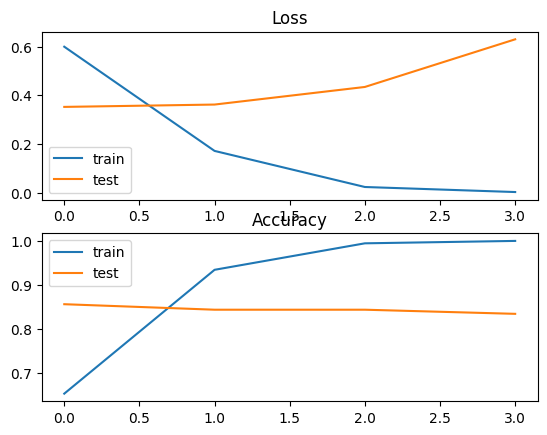

In [ ]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()